In [43]:
import pandas as pd
import seaborn as sns
import nltk
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from numpy import asarray
from numpy import zeros
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import LSTM
from keras.layers import Conv1D, GlobalMaxPooling1D, Dense
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import precision_score, recall_score, accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.datasets import imdb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.preprocessing import sequence
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

## LABELING DENGAN WORD-BASED-LEARNING ##

In [44]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

# Membaca dataset
data = pd.read_csv('preprocessed_comments.csv')

# Menginisialisasi SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Fungsi untuk memberikan label sentimen
def label_sentiment(text):
    if isinstance(text, float):
        return 'neutral'  # or any other label for float values
    sentiment_score = sia.polarity_scores(text)['compound']
    if sentiment_score >= 0:
        return 'positive'
    else:
        return 'negative'

# Memberikan label sentimen pada dataset
data['Labels'] = data['Preprocessed_Comment'].apply(label_sentiment)

# Menyimpan dataset dengan label sentimen
data.to_csv('labeled_dataset.csv', index=False)

## LOAD DATA ##

In [45]:
ikn_data = pd.read_csv("labeled_dataset.csv", delimiter=";")

In [46]:
ikn_data.shape

(9328, 1)

In [47]:
ikn_data.head(5)

,"Preprocessed_Comment,Labels"
0,jika anggaran di total mngenai pembangunan jak...
1,"alhamdulillah ,positive"
2,dibangun oleh beliau dan dinikmati oleh genera...
3,semua akan di nikmati oleh cucu kita di jaman ...
4,pak jokowi jangan hanya pembangunan nya saja k...


In [48]:
ikn_data.isnull().values.any()

False

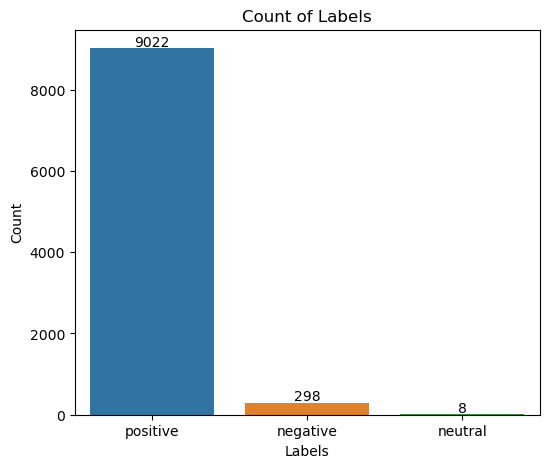

In [49]:
# Load the data
ikn_data = pd.read_csv('labeled_dataset.csv')

# Get the counts for each label type
label_counts = ikn_data['Labels'].value_counts()

# Plot the count of labels
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 5))
sns.countplot(x='Labels', data=ikn_data, ax=ax)

# Add the label counts on top of the bars
for i, v in enumerate(label_counts):
    ax.text(i, v + 50, str(v), color='black', ha='center')

ax.set_title('Count of Labels')
ax.set_xlabel('Labels')
ax.set_ylabel('Count')

plt.show()

## Data Pre-Processing ##

In [50]:
ikn_data["Preprocessed_Comment"][2]

'dibangun oleh beliau dan dinikmati oleh generasi berikutnya dan pemimpin selanjutnya btw saya kira kalau pengganti tahun menjabat trus pak jokowi nyapres lagi apa bisa berarti kemungkinan periode lg kalau cukup umurnya apa gitu ya '

In [51]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [52]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [54]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stopwords composed of A-Z & a-z only
    in lowercase'''
    if isinstance(sen, float):
        return ''
    sentence = sen.lower()
    # Remove html tags
    sentence = remove_tags(sentence)
    # Remove punctuations and special characters
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    # Remove stopwords and words with length less than 2
    words = sentence.split()
    words = [word for word in words if word not in stopwords.words('english') and len(word) > 1]
    # Join the words back into a single string
    sentence = ' '.join(words)
    return sentence

In [55]:
# Calling preprocessing_text function on ikn_data

X = []
sentences = list(ikn_data['Preprocessed_Comment'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [56]:
# Sample cleaned up ikn data

X[2]

'dibangun oleh beliau dan dinikmati oleh generasi berikutnya dan pemimpin selanjutnya btw saya kira kalau pengganti tahun menjabat trus pak jokowi nyapres lagi apa bisa berarti kemungkinan periode lg kalau cukup umurnya apa gitu ya'

In [57]:
# Converting sentiment labels to 0 & 1

y = ikn_data['Labels']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [58]:
# Membagi dataset menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Menyiapkan Embedding Layer ##

### Word Tokenizer ###

In [59]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

# Mengubah teks menjadi urutan token
X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [60]:
# Padding sequence agar memiliki panjang yang sama
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [61]:
# Menambahkan 1 untuk menyimpan dimensi untuk kata yang tidak memiliki penyematan kata yang telah dilatih sebelumnya

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

15961

In [62]:
# Load GloVe word embeddings
embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

# Create embedding matrix
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [63]:
embedding_matrix.shape

(15961, 100)

## Model Training ##

## CNN ##

In [64]:
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input

In [65]:
cnn_model = Sequential()

# Embedding layer
embedding_layer = Embedding(vocab_length, 100, trainable=False)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])
cnn_model.add(embedding_layer)

# Convolutional layer
cnn_model.add(Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.001)))

# Pooling layer
cnn_model.add(GlobalMaxPooling1D())

# Dense layers with regularization
cnn_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     1,596,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,596,100 (6.09 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,596,100 (6.09 MB)

In [66]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.1)

Epoch 1/6
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.8121 - loss: 0.6848 - val_accuracy: 0.9705 - val_loss: 0.3658
Epoch 2/6
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9674 - loss: 0.4154 - val_accuracy: 0.9705 - val_loss: 0.2954
Epoch 3/6
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9665 - loss: 0.3258 - val_accuracy: 0.9705 - val_loss: 0.2492
Epoch 4/6
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9684 - loss: 0.2365 - val_accuracy: 0.9705 - val_loss: 0.2173
Epoch 5/6
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9691 - loss: 0.1945 - val_accuracy: 0.9746 - val_loss: 0.2173
Epoch 6/6
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9814 - loss: 0.1631 - val_accuracy: 0.9746 - val_loss: 0.2111


In [67]:
# Predictions on the Test Set
score = cnn_model.evaluate(X_test, y_test, verbose=1)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9772 - loss: 0.1974


In [68]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.2124086618423462
Test Accuracy: 0.9748124480247498


In [69]:

# Misalkan x_test dan y_test adalah data uji dan labelnya
# Lakukan prediksi menggunakan model CNN yang telah dilatih
y_pred = cnn_model.predict(X_test)

# Karena y_pred dalam bentuk probabilitas (sigmoid), ubah menjadi label biner 0 atau 1
y_pred_binary = np.round(y_pred).astype(int)
y_test_binary = y_test.astype(int)  # Pastikan y_test dalam format yang sesuai

# Hitung MSE, RMSE, dan MAE
mse = mean_squared_error(y_test_binary, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_binary, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Mean Squared Error (MSE): 0.02195464970969072
Root Mean Squared Error (RMSE): 0.1481710150795044
Mean Absolute Error (MAE): 0.028473849289542483


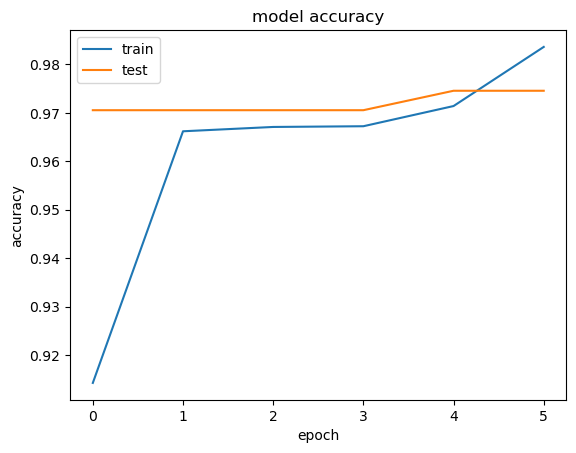

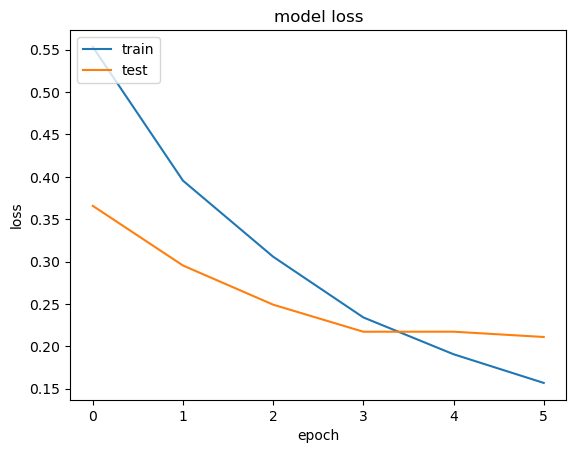

In [70]:
plt.plot(cnn_model_history.history['accuracy'])
plt.plot(cnn_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


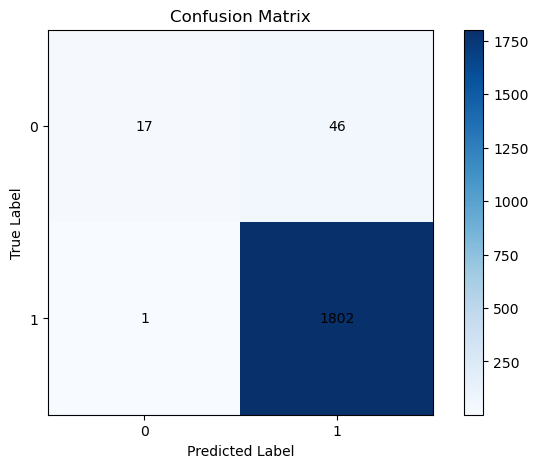

              precision    recall  f1-score   support

           0       0.94      0.27      0.42        63
           1       0.98      1.00      0.99      1803

    accuracy                           0.97      1866
   macro avg       0.96      0.63      0.70      1866
weighted avg       0.97      0.97      0.97      1866

True Positive (TP): 1802
True Negative (TN): 17
False Positive (FP): 46
False Negative (FN): 1
Accuracy: 0.9748
Precision: 0.9751
Recall: 0.9994
F1-Score: 0.9871


In [74]:
from sklearn.metrics import confusion_matrix, classification_report

# Misalkan x_test dan y_test adalah data uji dan labelnya
# Lakukan prediksi menggunakan model LSTM yang telah dilatih
y_pred = cnn_model.predict(X_test)

# Karena y_pred dalam bentuk probabilitas (sigmoid), ubah menjadi label biner 0 atau 1
y_pred_binary = np.round(y_pred).astype(int)
y_test_binary = y_test.astype(int)  # Pastikan y_test dalam format yang sesuai

# Hitung confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary).ravel()

# Hitung metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Tampilkan confusion matrix
plt.figure(figsize=(8, 5))
plt.imshow(confusion_matrix(y_test_binary, y_pred_binary), cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['0', '1'])
plt.yticks([0, 1], ['0', '1'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, confusion_matrix(y_test_binary, y_pred_binary)[i, j], ha='center', va='center', color='black')

plt.show()

# Tampilkan classification report
print(classification_report(y_test_binary, y_pred_binary))

# Tampilkan hasil perhitungan manual
print(f"True Positive (TP): {tp}")
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

## RNN - LSTM

In [29]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_length, 100, input_length=maxlen, trainable=False))
lstm_model.add(LSTM(128))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.4)

loss, accuracy = lstm_model.evaluate(X_test, y_test)
print(lstm_model.summary())

Epoch 1/10


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - accuracy: 0.9630 - loss: 0.3530 - val_accuracy: 0.9702 - val_loss: 0.1332
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.9644 - loss: 0.1535 - val_accuracy: 0.9702 - val_loss: 0.1338
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.9667 - loss: 0.1446 - val_accuracy: 0.9702 - val_loss: 0.1330
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 0.9659 - loss: 0.1477 - val_accuracy: 0.9702 - val_loss: 0.1318
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.9626 - loss: 0.1591 - val_accuracy: 0.9702 - val_loss: 0.1305
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9665 - loss: 0.1398 - val_accuracy: 0.9702 - val_loss: 0.1367
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.9649 - loss: 0.1466 - val_accuracy: 0.9702 - val_loss: 0.1361
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.9673 - loss: 0.1420 - val_accuracy: 0.9702 - val

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     1,596,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,948,233 (7.43 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 1,596,100 (6.09 MB)

 Optimizer params: 234,756 (917.02 KB)

None


# Build the LSTM model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
max_length = X.shape[1]


model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

In [30]:
# Assuming you have the following variables:
# X_train, y_train, X_test, y_test

# Display Training Data
print("Training Data:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Sample of X_train:")
print(X_train)
print("Sample of y_train:")
print(y_train)

# Display Test Data
print("\nTest Data:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Sample of X_test:")
print(X_test)
print("Sample of y_test:")
print(y_test)

Training Data:
X_train shape: (7462, 100)
y_train shape: (7462,)
Sample of X_train:
[[ 590  441   34 ...    0    0    0]
 [1368  715  197 ...    0    0    0]
 [   6  479   65 ...    0    0    0]
 ...
 [ 355  288  283 ...    0    0    0]
 [ 328 1276 1960 ...    0    0    0]
 [ 452   37 1353 ...    0    0    0]]
Sample of y_train:
[1 0 1 ... 1 1 1]

Test Data:
X_test shape: (1866, 100)
y_test shape: (1866,)
Sample of X_test:
[[ 549   56    5 ...    0    0    0]
 [  52 2450  915 ...    0    0    0]
 [  41  137   47 ...    0    0    0]
 ...
 [2001    0    0 ...    0    0    0]
 [  70   50    9 ...    0    0    0]
 [  65   36    2 ...    0    0    0]]
Sample of y_test:
[1 0 1 ... 1 1 1]


In [31]:
# Predictions on the Test Set
score = lstm_model.evaluate(X_test, y_test, verbose=1)

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9719 - loss: 0.1322


In [32]:
# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.14622944593429565
Test Accuracy: 0.9662379622459412


In [33]:
# Misalkan x_test dan y_test adalah data uji dan labelnya
# Lakukan prediksi menggunakan model CNN yang telah dilatih
y_pred = lstm_model.predict(X_test)

# Karena y_pred dalam bentuk probabilitas (sigmoid), ubah menjadi label biner 0 atau 1
y_pred_binary = np.round(y_pred).astype(int)
y_test_binary = y_test.astype(int)  # Pastikan y_test dalam format yang sesuai

# Hitung MSE, RMSE, dan MAE
mse = mean_squared_error(y_test_binary, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_binary, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
Mean Squared Error (MSE): 0.03235487741912699
Root Mean Squared Error (RMSE): 0.17987461582760084
Mean Absolute Error (MAE): 0.07876316342195386


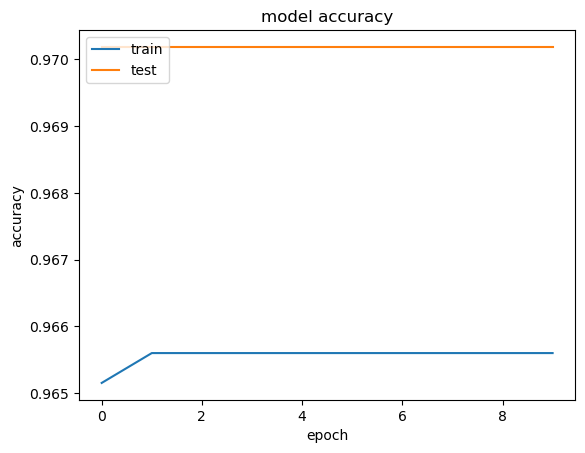

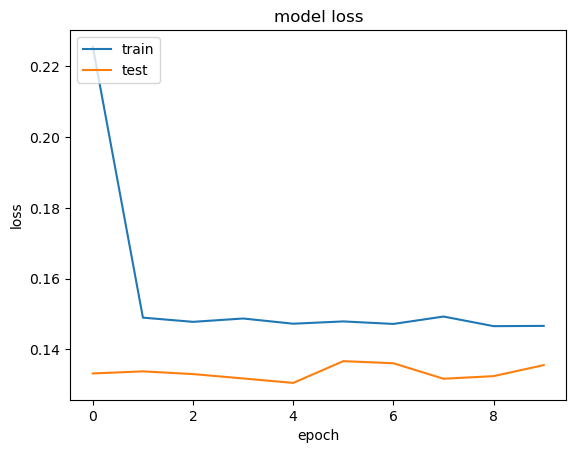

In [34]:
plt.plot(lstm_model_history.history['accuracy'])
plt.plot(lstm_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


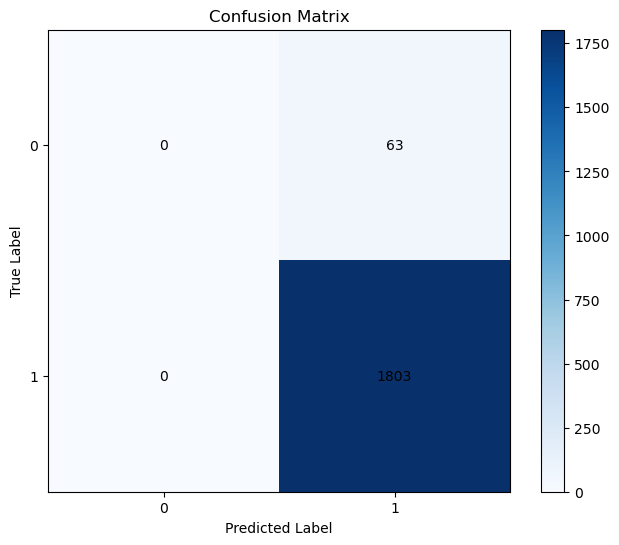

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.97      1.00      0.98      1803

    accuracy                           0.97      1866
   macro avg       0.48      0.50      0.49      1866
weighted avg       0.93      0.97      0.95      1866



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Misalkan x_test dan y_test adalah data uji dan labelnya
# Lakukan prediksi menggunakan model LSTM yang telah dilatih
y_pred = lstm_model.predict(X_test)

# Karena y_pred dalam bentuk probabilitas (sigmoid), ubah menjadi label biner 0 atau 1
y_pred_binary = np.round(y_pred).astype(int)
y_test_binary = y_test.astype(int)  # Pastikan y_test dalam format yang sesuai

# Hitung confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)

# Tampilkan confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['0', '1'])
plt.yticks([0, 1], ['0', '1'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.show()

# Tampilkan classification report
print(classification_report(y_test_binary, y_pred_binary))

## WITH RECALL AND PRECISSION 

## PENANGANAN OVERFITTING 

## Making Predictions on Live IMDb data 

In [167]:
# Load previously trained LSTM Model

from keras.models import load_model

model_path ='C:\\Users\\user\\PENELITIAN SAINS DATA\\BARU\\code\\c1_lstm_model_acc_0.966.h5'
pretrained_lstm_model = load_model(model_path)

# # summarize model.
pretrained_lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     1,596,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,713,479 (6.54 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 1,596,100 (6.09 MB)

 Optimizer params: 2 (12.00 B)

In [145]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("preprocessed_comments.csv")
sample_reviews.head(6)

,Preprocessed_Comment
0,jika anggaran di total mngenai pembangunan jak...
1,alhamdulillah
2,dibangun oleh beliau dan dinikmati oleh genera...
3,semua akan di nikmati oleh cucu kita di jaman ...
4,pak jokowi jangan hanya pembangunan nya saja k...
5,pak die tolong dong aq mesan mcb kwh listrik d...


In [146]:
def preprocess_text(sen):
    if isinstance(sen, float):
        return ''
    sentence = sen.lower()
    sentence = remove_tags(sentence)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)
    return sentence

In [147]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Preprocessed_Comment']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [148]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [149]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

292/292 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step


array([[0.9695596 ],
       [0.9695622 ],
       [0.96955764],
       ...,
       [0.9695604 ],
       [0.9695616 ],
       [0.96956   ]], dtype=float32)

In [152]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = cnn_model.predict(unseen_padded)

unseen_sentiments

292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


array([[0.9972827 ],
       [0.95982766],
       [0.99907863],
       ...,
       [0.99045813],
       [0.51044345],
       [0.97925806]], dtype=float32)

In [153]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_comment                 = pd.DataFrame(sample_reviews['Preprocessed_Comment'], columns = ['Preprocessed_Comment'])

dfx=pd.concat([df_comment, df_prediction_sentiments], axis=1)

dfx.to_csv("predicted_data.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Preprocessed_Comment,Predicted Sentiments
0,jika anggaran di total mngenai pembangunan jak...,10.0
1,alhamdulillah,9.6
2,dibangun oleh beliau dan dinikmati oleh genera...,10.0
3,semua akan di nikmati oleh cucu kita di jaman ...,10.0
4,pak jokowi jangan hanya pembangunan nya saja k...,9.8
5,pak die tolong dong aq mesan mcb kwh listrik d...,10.0


# 

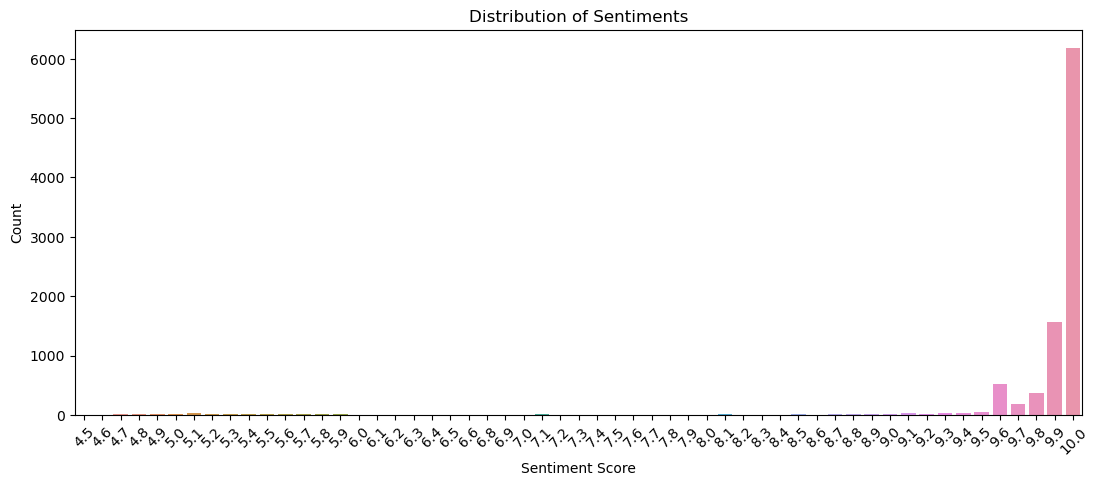

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the data
df = pd.read_csv('predicted_data.csv')

# Count the number of each sentiment
sentiment_counts = df['Predicted Sentiments'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(13, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')
plt.xticks(rotation=45)
plt.show()